# Face detection and BMI/Age/Sex prediction

The model provides end-to-end capability of detecting faces and predicting the BMI, Age and Gender for each person. 

The archetecture of the model is described as below:

![](./img/model_structure.jpg)


## Face detection

Face detection is done by `MTCNN`, which is able to detect multiple faces within an image and draw the bounding box for each faces.  

It serves two purposes for this project:

### 1) preprocess and align the facial features of image.

Prior model training, each image is preprocessed by `MTCNN` to extract faces and crop images to focus on the facial part. The cropped images are saved and used to train the model in later part.

Illustration of face alignment:
![](./img/mtcnn_face_alignment.jpg)

### 2) enable prediction for multiple persons in the same image.

In inference phase, faces will be detected from the input image. For each face, it will go through the same preprocssing and make the predictions.

Illustration of ability to predict for multiple faces:
![](./img/detect_predict_multi_faces.png)

## Multi-task prediction

In vannlia CNN archtecture, convolutionary blocks are followed by the dense layers to make output the prediction. In a naive implementation, we can build 3 models to predict BMI, age and gender individually. However, there is a strong drawback that 3 models are required to be trained and serialized separately, which drasmatically increases the mantainence efforts.

|   |
|---|
|`[input image] => [VGG16] => [dense layers] => [BMI]`|
|`[input image] => [VGG16] => [dense layers] => [AGE]`|
|`[input image] => [VGG16] => [dense layers] => [SEX]`|

Since we are going to predict `BMI`, `Age`, `Sex` from the same image, we can share the same backbone for the three different prediction heads and hence only one model will be maintained.

|    |
|----|
|`[input image] => [VGG16] => [separate dense layers] x3 => weighted([BMI], [AGE], [SEX])`|

This is the most simplifed multi-task learning structure, which assumed independent tasks and hence separate dense layers were used for each head. Other research such as `Deep Relationship Networks`, used `matrix priors` to model the relationship betweeen tasks.

![](https://ruder.io/content/images/2017/05/relationship_networks.png)
_A Deep Relationship Network with shared convolutional and task-specific fully connected layers with matrix priors (Long and Wang, 2015)._
 
## Reference
 * MTCNN: [https://github.com/ipazc/mtcnn](https://github.com/ipazc/mtcnn)
 * VGGFace: [https://github.com/rcmalli/keras-vggface](https://github.com/rcmalli/keras-vggface)

In [1]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16_fc6'
model_dir = './saved_model/model_'+model_type + '.h5'
bs = 8
epochs = 20

In [2]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
from models import FacePrediction

allimages = os.listdir('./face_aligned/')
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')

train = train.loc[train['index'].isin(allimages)]
valid = valid.loc[valid['index'].isin(allimages)]

Using TensorFlow backend.


## Data

This is fairly small dataset, which comprises 1530 records and  16 columns.

* sex imbalance: 80% of the data is male
* age is near truncated normal distribution. min Age is 18, average Age is 34.
* race is dominated by Black and White. Asian samples are very limited.
* BMI is normal distrbuted, with mean at 26.

* no obvious correlation found between BMI and Age, Sex.

In [3]:
data = pd.concat([train, valid])
data[['age','race','sex','bmi','index']].head()

age   race   sex        bmi       index
0   54  Black  Male  39.047808  248038.jpg
1   26  Black  Male  29.285856  250464.jpg
2   24  White  Male  42.820836  263711.jpg
3   21  Black  Male  23.025951  270020.jpg
4   18  White  Male  19.004109  279426.jpg

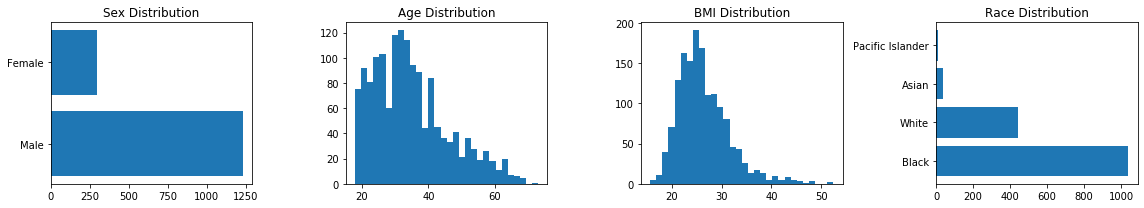

In [4]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches((16, 3))
axs[0].barh(data.sex.unique(), data.sex.value_counts())
axs[0].set_title('Sex Distribution')
axs[1].hist(data.age, bins = 30)
axs[1].set_title('Age Distribution')
axs[2].hist(data.bmi, bins = 30)
axs[2].set_title('BMI Distribution')
axs[3].barh(data.race.unique(), data.race.value_counts())
axs[3].set_title('Race Distribution')
plt.tight_layout()

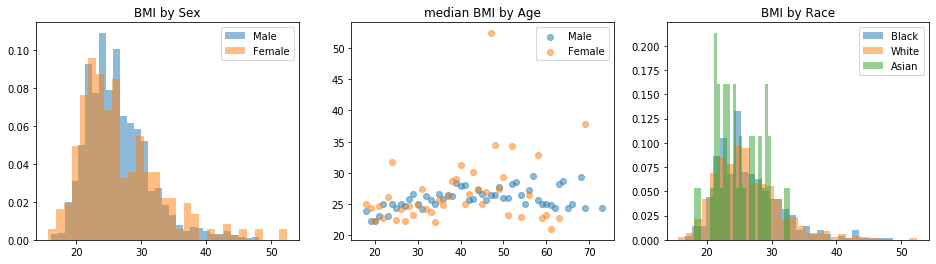

In [5]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches((16, 4))

for i in ['Male','Female']:
    axs[0].hist(data.loc[data.sex == i,'bmi'].values, label = i, alpha = 0.5, density=True, bins = 30)
axs[0].set_title('BMI by Sex')
axs[0].legend()

res = data.groupby(['age','sex'], as_index=False)['bmi'].median()
for i in ['Male','Female']:
    axs[1].scatter(res.loc[res.sex == i,'age'].values, res.loc[res.sex == i,'bmi'].values,label = i, alpha = 0.5)
axs[1].set_title('median BMI by Age')
axs[1].legend()

for i in ['Black','White','Asian']:
    axs[2].hist(data.loc[data.race == i,'bmi'].values, label = i, alpha = 0.5, density=True, bins = 30)
axs[2].set_title('BMI by Race')
axs[2].legend()

plt.show()

## Training

In [6]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_type))
callbacks = [es, ckp, tb]

model = FacePrediction(img_dir = './face_aligned/', model_type = model_type)
model.define_model()
model.model.summary()
if mode == 'train':
    model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

W0117 07:15:31.745581 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\mtcnn\mtcnn.py:187: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0117 07:15:31.747583 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\mtcnn\mtcnn.py:193: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0117 07:15:32.436701 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\mtcnn\network.py:43: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0117 07:15:32.436701 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\mtcnn\layer_factory.py:88: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 07:15:32.441701 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\sit

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

W0117 07:15:40.215739 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0117 07:15:40.220739 10940 deprecation_wrapper.py:119] From C:\Users\n174724\.conda\envs\face2bmi\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
153/153 [==============================] - 29s 189ms/step - loss: 19.5044 - bmi_loss: 20.6940 - age_loss: 29.2519 - sex_loss: 0.2398 - sex_acc: 0.8987 - val_loss: 13.2211 - val_bmi_loss: 13.7556 - val_age_loss: 22.0438 - val_sex_loss: 0.1222 - val_sex_acc: 0.9737

Epoch 00001: val_loss improved from inf to 13.22109, saving model to ./saved_model/model_vgg16_fc6.h5
Epoch 2/20
153/153 [==============================] - 25s 165ms/step - loss: 7.4569 - bmi_loss: 7.5345 - age_loss: 14.1989 - sex_loss: 0.0944 - sex_acc: 0.9673 - val_loss: 6.4341 - val_bmi_loss: 7.1028 - val_age_loss: 7.4562 - val_sex_loss: 0.0628 - val_sex_acc: 0.9803

Epoch 00002: val_loss improved from 13.22109 to 6.43411, saving model to ./saved_model/model_vgg16_fc6.h5
Epoch 3/20
153/153 [==============================] - 25s 164ms/step - loss: 3.6682 - bmi_loss: 3.8495 - age_loss: 5.8151 - sex_loss: 0.0708 - sex_acc: 0.9755 - val_loss: 4.0412 - val_bmi_loss: 4.2947 - val_age_loss: 5.9680 - val_sex_loss: 0.087

## Evaluations

![](./img/tensorboard_results.png)

| Model | BMI (RMSE) | Age (RMSE) | Sex (AUC) |
|-------|------------|------------|-----------|
|vgg16  |4.56|5.66|0.99|
|vgg16_fc6| 4.99 | 6.04 | 0.99 |
|resnet50|5.21 | 7.02 | 0.99|

In [7]:
metrics = model.evaulate(valid)
metrics['model'] = model_type
with open('./metrics/{:s}.json'.format(model_type), 'w') as f:
    json.dump(metrics, f)
metrics

{'bmi_rmse': 4.992019501915523,
 'age_rmse': 6.0496795729235915,
 'sex_auc': 0.9949610319806503,
 'model': 'vgg16_fc6'}

## Predictions

### predict from a single image

In [8]:
model.predict('./test_aligned/trump.jpg')

[array([[28.611212]], dtype=float32),
 array([[64.24111]], dtype=float32),
 array([[0.12481199]], dtype=float32)]

### predict from a directory

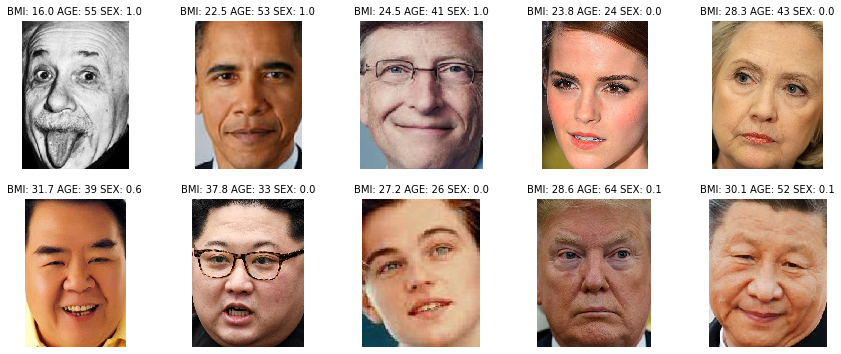

In [9]:
preds = model.predict('./test_aligned/', show_img = True)

In [10]:
model.predict_df('./test_aligned')

img        bmi        age     sex  sex_prob
0  albert-einstein.jpg  16.045193  55.480125    Male  0.996355
1     barack-obama.jpg  22.523438  52.913406    Male  0.999517
2       bill-gates.jpg  24.511267  40.906231    Male  0.999629
3      emma_watson.jpg  23.799431  23.705317  Female  0.002271
4   hilary_clinton.jpg  28.335468  43.432491  Female  0.000032
5       kent_zheng.jpg  31.680971  38.529037    Male  0.581396
6      Kim Jong-un.jpg  37.771263  33.331184  Female  0.010079
7        leonardo.jpeg  27.203665  26.458378  Female  0.008024
8            trump.jpg  28.611210  64.241142    Male  0.124812
9               xi.jpg  30.061153  51.594566    Male  0.081935

### predict multiple faces

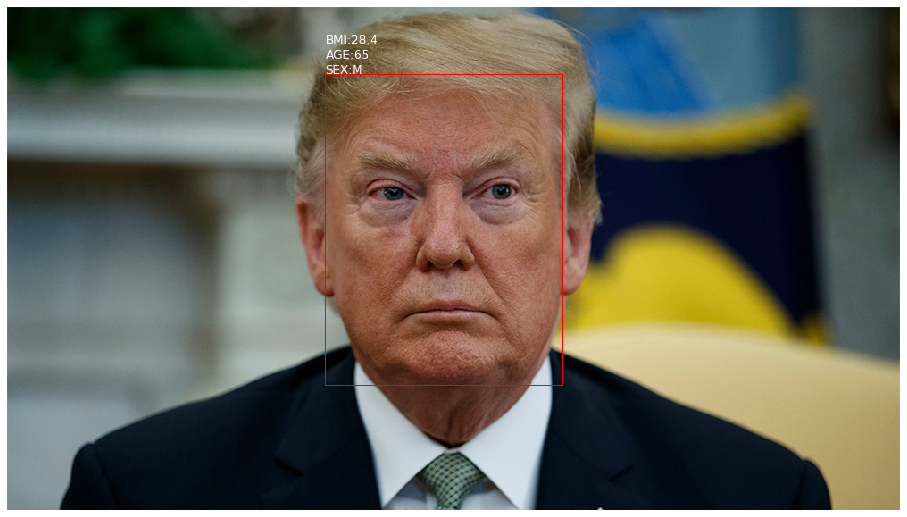

In [11]:
preds = model.predict_faces('./test/trump.jpg')

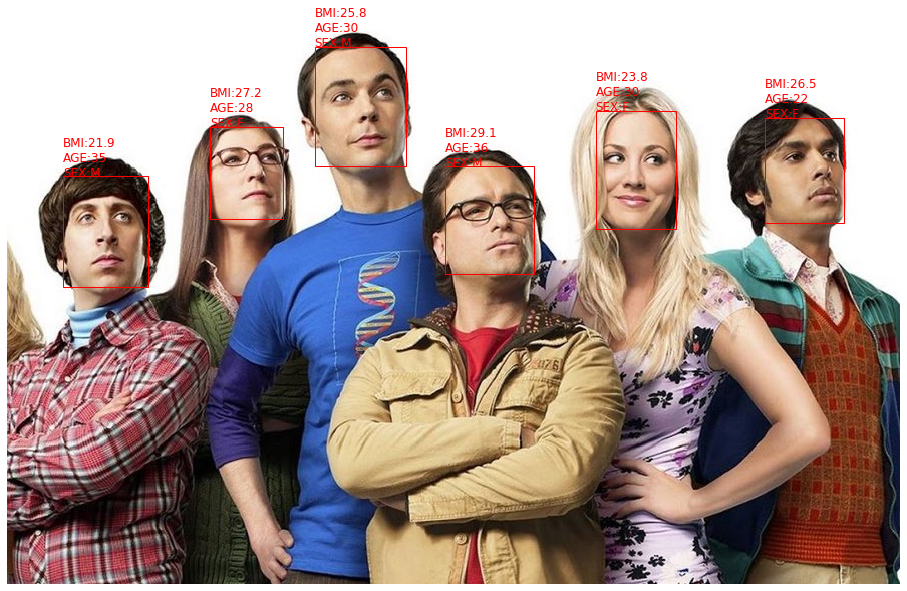

In [12]:
preds = model.predict_faces('./test_mf/the-big-bang-theory-op-netflix.jpg', color = 'red')

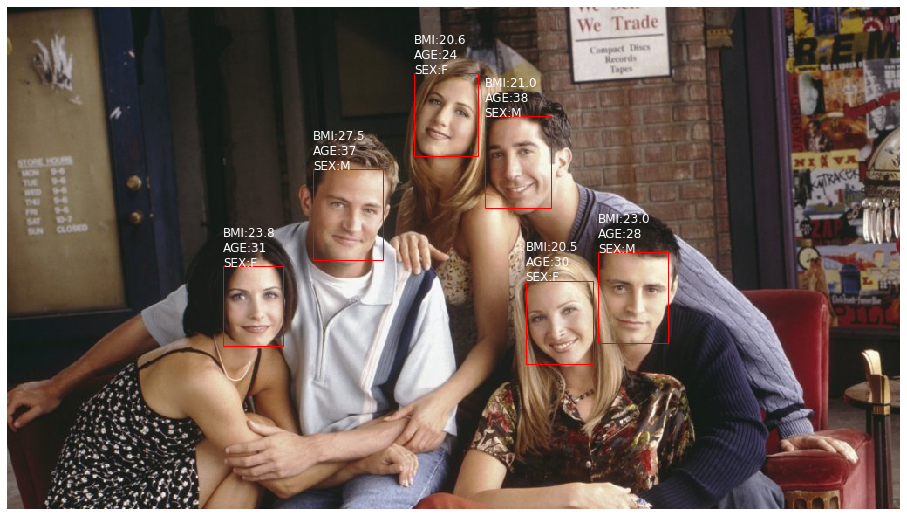

In [13]:
preds = model.predict_faces('./test_mf/friends.jpg', color = 'white')

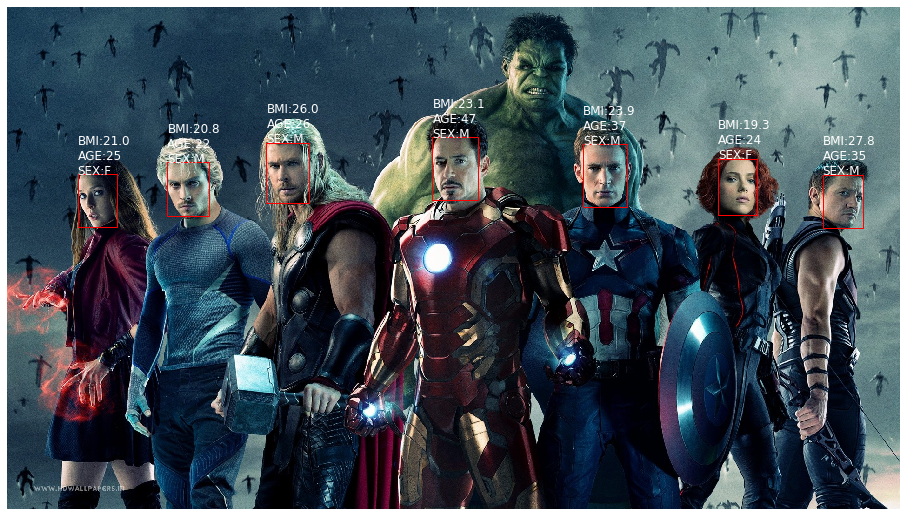

In [14]:
preds = model.predict_faces('./test_mf/avengers.jpg', color = 'white')

### Asians

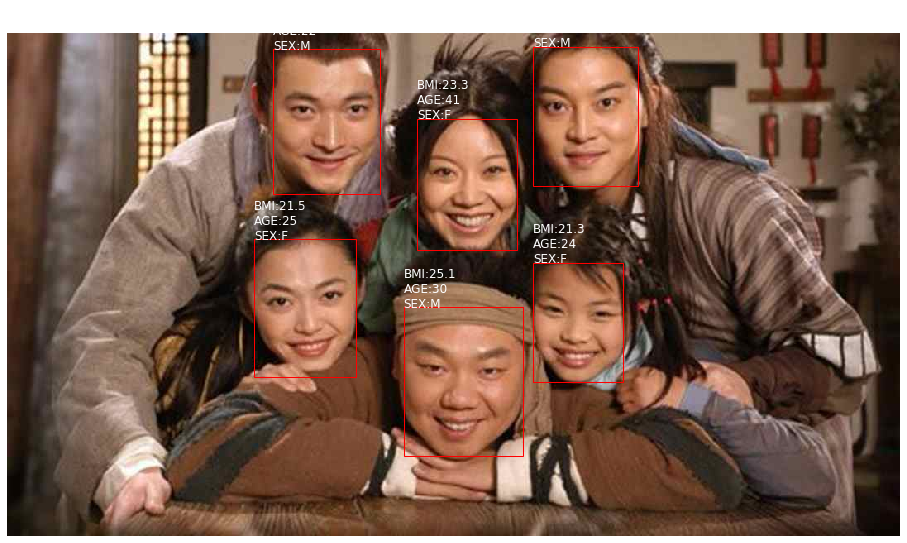

In [15]:
preds = model.predict_faces('./test_mf/wulinwaizhuan.jpg', color = 'white')